# EDA SPEEDS DATASET


This dataset consists of speeds captured with the Bitcarrier sensor system (real-time intelligent traffic flow information and monitoring system) from wireless WI-FI and Bluetooth sensors, emitted by mobile devices on the road network of Bogota D.C. for the month of January 2022. It is in CSV format and was extracted from the Open Data from the [Secretaría Distrital de Movilidad](https://datos.movilidadbogota.gov.co/datasets/movilidadbogota::velocidades-bitcarrier-enero2022-24h/explore?location=4.630679%2C-74.063436%2C15.98). Speeds correspond to quarter-hourly averages during 24 hours. The dataset has 2'660.955 observations and 23 columns. Some important features are the following:

**OBJECT_ID**: Identifier of the measurement.

**TID**: Identifier of the section of road where the speed is monitored.

**INICIO, FIN**: Start and end date and hour of the measurement.

**DISTANCE**: Length of the section of road.

**VEL_PROMEDIO**: Average speed in the section of road.

**NAME_FROM**: Name of the first address of the section of road.

**NAME_TO**: Tuple consisting of the secondary start and end address of the section of road.

Besides these, there's other features highlighting temporal aspects of the measurement like for example: (AÑO, HORA, CUARTO_HORA, DIA_SEMANA, MES). There's also a few features relating to the speed: (CODIGO, COEF_BRT, COEF_MIXTO, VEL_MEDIA_PONDERADA, VEL_MEDIA_BRT, VEL_MEDIA_MIXTO).


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import folium


pd.options.display.max_columns = None

In [2]:
speeds = pd.read_csv("../0_datasets/speeds/Velocidades_Bitcarrier_Enero2022_24H_SUBSET.csv", parse_dates=["INICIO", "FIN"])

Let's look at the first columns:


In [3]:
speeds.shape

(250000, 23)

In [4]:
speeds.head()

,OBJECTID,TID,INICIO,FIN,AÑO,HORA,DISTANCE,TYPE,VEL_PROMEDIO,CUARTO_HORA,DIA_SEMANA,MES,NAME_FROM,NAME_TO,VEL_PONDERADA,CODIGO,COEF_BRT,COEF_MIXTO,VEL_MEDIA_BRT,VEL_MEDIA_MIXTO,VEL_MEDIA_PONDERADA,NUMDISPOSITIVOS,SHAPE_Length
0,1,1002075,2022-01-01 00:00:00+00:00,2022-01-01 00:14:59+00:00,2022,0,696.0,1.0,54.666667,12:00:00,Sabado,January,CL80,KR71;KR76,54.666667,NaN,NaN,NaN,NaN,NaN,NaN,3,0.006276
1,2,1002065,2022-01-01 00:00:00+00:00,2022-01-01 00:14:59+00:00,2022,0,684.0,1.0,34.620000,12:00:00,Sabado,January,KR19,CL140;CL147,34.620000,NaN,NaN,NaN,NaN,NaN,NaN,3,0.006185
2,3,1002042,2022-01-01 00:00:00+00:00,2022-01-01 00:14:59+00:00,2022,0,995.0,1.0,77.403333,12:00:00,Sabado,January,CL26,AV.ROJAS;NORMANDIA,75.920000,NaN,NaN,NaN,NaN,NaN,NaN,4,0.008991
3,4,1002078,2022-01-01 00:00:00+00:00,2022-01-01 00:14:59+00:00,2022,0,719.0,1.0,5.250000,12:00:00,Sabado,January,KR60,CL53;CL26,2.625000,NaN,NaN,NaN,NaN,NaN,NaN,2,0.006490
4,5,1002088,2022-01-01 00:00:00+00:00,2022-01-01 00:14:59+00:00,2022,0,441.0,1.0,39.696667,12:00:00,Sabado,January,KR86,CL19A;CL22,39.372500,NaN,NaN,NaN,NaN,NaN,NaN,4,0.003987


### Missing values


Theres some columns that just contain null values, let's drop them. Also the MES and YEAR columns are redundant as all the data is from May 2022.


In [5]:
speeds = speeds.drop(
    ["CODIGO", "COEF_BRT", 
     "COEF_MIXTO", "VEL_MEDIA_PONDERADA",
     "VEL_MEDIA_BRT", "VEL_MEDIA_MIXTO",
     "VEL_PONDERADA", "MES", "AÑO"], axis=1)

As we can't infer the missing values, we are going to remove them.

In [6]:
speeds = speeds.dropna()

### Speeds analysis


Summary statistics:


In [7]:
speeds["VEL_PROMEDIO"].describe().to_frame()

,VEL_PROMEDIO
count,246328.000000
mean,33.541157
std,14.827613
min,4.010000
25%,22.843333
50%,31.616667
75%,42.046667
max,185.503333


Speeds distribution:


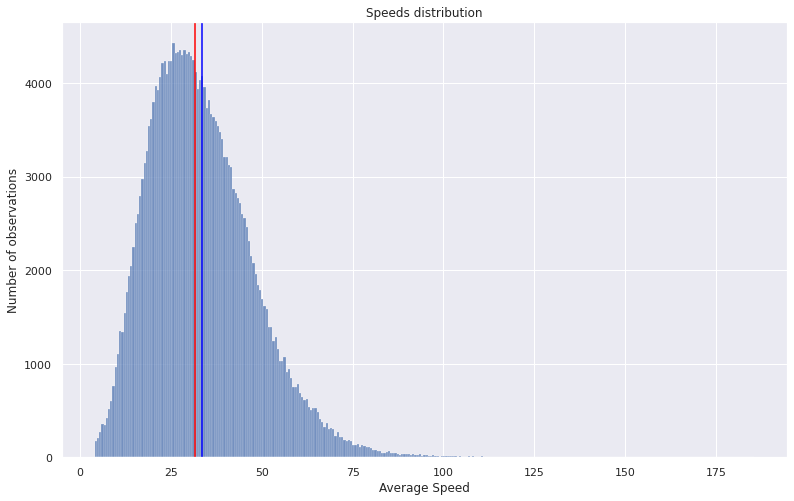

In [8]:
plt.figure(figsize=(13,8))
sns.set(style="darkgrid")
sns.histplot(speeds["VEL_PROMEDIO"])
plt.title("Speeds distribution")
plt.ylabel("Number of observations")
plt.xlabel("Average Speed")
plt.axvline(x=speeds["VEL_PROMEDIO"].mean(),
            color='blue')
plt.axvline(x=speeds["VEL_PROMEDIO"].median(),
            color='red')
plt.show()

### Speeds v.s. Time


Now let's visualize the average speed in Bogotá per hour of the day and per day of the week:


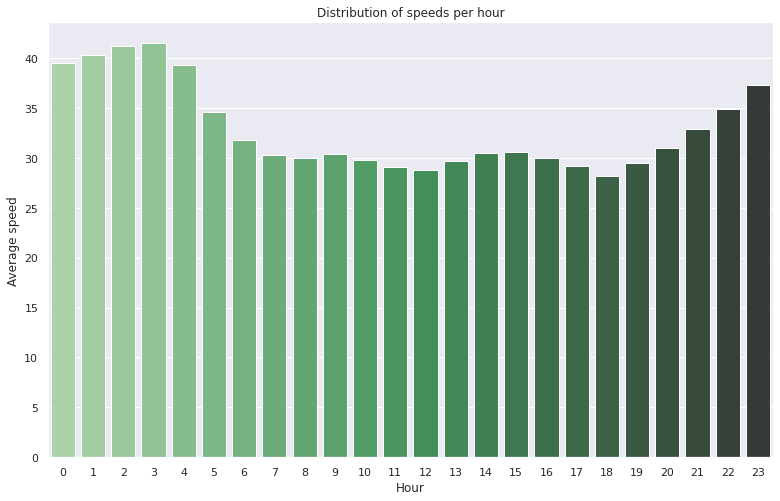

In [9]:
speeds_per_hour = speeds.groupby("HORA")["VEL_PROMEDIO"].mean().to_frame().reset_index()

plt.figure(figsize=(13,8))
sns.barplot(x="HORA", y="VEL_PROMEDIO", data=speeds_per_hour, palette="Greens_d") 
plt.title('Distribution of speeds per hour')
plt.xlabel('Hour')
plt.ylabel('Average speed')
plt.show()

As expected people go faster late at night, perhaps because there's less traffic and people in general at those times. Meanwhile from 6 a.m to 5 p.m, the speeds decrease plateauning around 25 km/h.


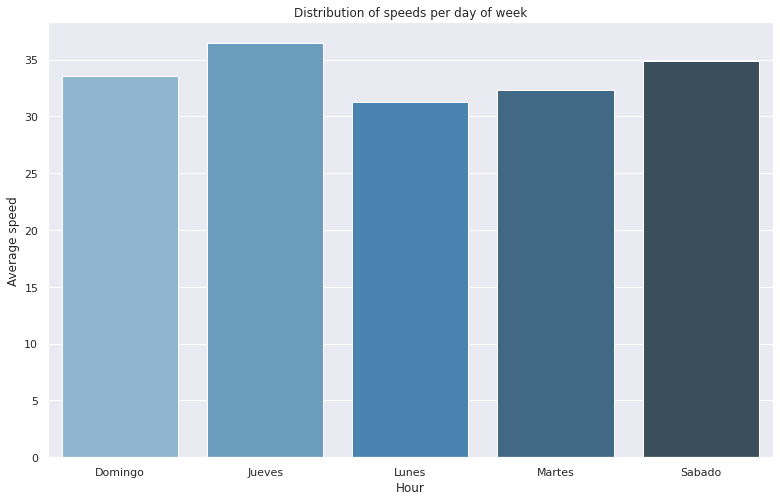

In [10]:
speeds_per_day_of_week = speeds.groupby("DIA_SEMANA")["VEL_PROMEDIO"].mean().to_frame().reset_index()

plt.figure(figsize=(13,8))
sns.barplot(x="DIA_SEMANA", y="VEL_PROMEDIO", data=speeds_per_day_of_week, palette="Blues_d")
plt.title('Distribution of speeds per day of week')
plt.xlabel('Hour')
plt.ylabel('Average speed')
plt.show()

The average speed does not seem to be affected by the day of the week.


### Speeds per location


In [11]:
speeds.groupby("NAME_FROM")["VEL_PROMEDIO"].mean().sort_values(ascending=False).to_frame().head(5)

,VEL_PROMEDIO
NAME_FROM,
"AV.AMERICAS,KR50",71.698369
CL26,56.428882
AV.CL59SUR,49.988409
AUTONORTE,49.974148
AV.CIRCUNVALAR,48.672416


In [12]:
speeds.groupby("NAME_FROM")["VEL_PROMEDIO"].mean().sort_values().to_frame().head(5)

,VEL_PROMEDIO
NAME_FROM,
CL39,10.208952
CL66A,13.265510
CL57,13.480464
"CL19,KR3",14.255335
CL22,14.768908


### Geo information


In [13]:
road_geoms = gpd.read_file("../0_datasets/speeds/unique_road_segments.geojson")

In [14]:
m = folium.Map(location=[4.624, -74.1], tiles="OpenStreetMap", zoom_start=11.5)
folium.GeoJson(data=road_geoms).add_to(m)
m

#### Folium heatmap


In [15]:
avg_speeds = speeds.groupby(["TID", "NAME_FROM", "NAME_TO", "DISTANCE"])["VEL_PROMEDIO"].mean().to_frame().reset_index()

In [16]:
avg_speeds = gpd.GeoDataFrame(avg_speeds.merge(road_geoms, on="TID"))

In [17]:
colormap = folium.branca.colormap.linear.Oranges_08.scale(
    avg_speeds.VEL_PROMEDIO.min(),
    avg_speeds.VEL_PROMEDIO.max())
colormap.caption = "Rango de velocidades promedio."


In [18]:
style_fun = lambda x: {"weight" : 2, "color": colormap(x["properties"]["VEL_PROMEDIO"])}

tooltip = folium.GeoJsonTooltip(["TID", "NAME_FROM", "NAME_TO", "DISTANCE"])

bogo_map = folium.Map(location=[4.624, -74.1], zoom_start=12)

folium.TileLayer('cartodbdark_matter',name="Dark Map",control=False).add_to(bogo_map)
colormap.add_to(bogo_map)
folium.GeoJson(
    data=avg_speeds,
    style_function = style_fun,
    tooltip=tooltip
).add_to(bogo_map)

bogo_map

### Road GeoHeatmap by hour of the day

In [19]:
def time_day(hour):
    if 5 <= hour <=10:
        return "Morning"
    elif 10 < hour <= 15:
        return "Midday"
    elif 15 < hour <= 18:
        return "Afternoon"
    elif 18 < hour <= 22:
        return "Night"
    else:
        return "Latenight"

In [20]:
speeds["time_day"] = speeds["HORA"].map(time_day)